<a href="https://colab.research.google.com/github/shikharkyadesultory/GNN_resilient_network/blob/main/(Updated)DUFFINGbased_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch_geometric

In [2]:
!pip install torch_scatter

In [ ]:
import torch
import torch.nn as nn
import torch_geometric.nn as pyg_nn
import numpy as np
from torch_geometric.utils import degree
from torch_scatter import scatter_add
import matplotlib.pyplot as plt

class DuffingGNNFilter(nn.Module):
  def __init__(self,in_channels,out_channels,C=0.2,delta=0.5,omega=1.0):
    super().__init__()
    self.C = C
    self.delta = delta
    self.omega = omega
    self.a = nn.Parameter(torch.randn(1))

    self.linear_x = pyg_nn.Linear(in_channels,out_channels)
    self.linear_y = pyg_nn.Linear(in_channels,out_channels)
    self.linear_x_cubic = pyg_nn.Linear(in_channels,out_channels) ## for the cubic term

  def forward(self,x,edge_index,edge_weight=None):
    row,col = edge_index
    deg = degree(row, x.size(0), dtype = x.dtype)
    deg_inv = 1.0/deg.clamp_min(1)

    linear_x_out = self.linear_x(x)
    linear_y_out = self.linear_y(x)
    linear_x_cubic_out = self.linear_x_cubic(x**3)

    if edge_weight is None:
      edge_weight = torch.ones(edge_index.size(1),device=x.device)

    weighted_linear_y_out = linear_y_out[col] * edge_weight.view(-1 , 1) * deg_inv[col].view(-1 , 1)
    Lx = scatter_add(weighted_linear_y_out,row,dim=0, dim_size = x.size(0))

    coupling = -self.C * Lx
    x_dot = linear_y_out + coupling
    y_dot = linear_x_out - linear_x_cubic_out - self.delta * linear_y_out + self.a * torch.sin(self.omega * torch.arange(x.size(0) , device = x.device)).unsqueeze(-1) ## Assuming for correct broadcast
    dt = 0.1
    x_new = linear_x_out + dt * x_dot
    y_new = linear_y_out + dt * y_dot
    return x_new,y_new

class SpectralDuffingGNN(nn.Module):
  def __init__(self,num_features,hidden_dim,num_classes,num_layers=3):
    super().__init__()
    self.layers = nn.ModuleList()
    self.layers.append(DuffingGNNFilter(num_features,hidden_dim))
    ## for the hidden layer ##

    for _ in range(num_layers - 2):
      self.layers.append(DuffingGNNFilter(hidden_dim,hidden_dim))
    ## for the output layer ##
    self.layers.append(DuffingGNNFilter(hidden_dim,num_classes))
    self.omega_params = nn.ParameterList([nn.Parameter(torch.randn(1)) for _ in range(num_layers)])

  def forward(self,x,edge_index):
    for i,layer in enumerate(self.layers):
      layer.omega = self.omega_params[i].abs() ## only positive frequencies
      x,_ = layer(x,edge_index)
    return x

**Developing Star Network for Application**

In [ ]:
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

N = 15
num_features = 8
num_classes = 3
G = nx.star_graph(N - 1)

## creating dummy features and label data##
x = torch.randn(N, num_features)
y = torch.randint(0,num_classes,(N,))

## adding features and labels to the networkx graph ##
for i in range(N):
  G.nodes[i]['x'] = x[i].tolist()
  G.nodes[i]['y'] = y[i].item()

## converting NetworkX graph to torch_geometric.data.Data object ##
data = from_networkx(G)

print(" *** Star Graph Data with Features and Classes ***")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of features per node: {data.x.shape[1]}")
print(f"Number of classes (max label + 1): {data.y.max().item() + 1}")
print("\nContents of the Data object:")
print(data)
num_classes = data.y.max().item() + 1
model = SpectralDuffingGNN(num_features=data.num_features,hidden_dim=32,num_classes=num_classes,num_layers=4)
optimizer = torch.optim.Adam(model.parameters(),lr=0.01,weight_decay=5e-4)
model.train()
print(model)


### STAR NETWORK DEFINED FOR REST OF THE FILTER AND GNN USES ###


def normalize_GSO(gso):
  eig_val,eig_vec = np.linalg.eig(gso)
  return gso/np.max(eig_val.real)
M = nx.adjacency_matrix(G)
M_tensor = torch.tensor(M.todense(),dtype=torch.float)
data_gso = normalize_GSO(M_tensor)
print(data_gso)

 *** Star Graph Data with Features and Classes ***
Number of nodes: 15
Number of features per node: 8
Number of classes (max label + 1): 3

Contents of the Data object:
Data(x=[15, 8], edge_index=[2, 28], y=[15])
SpectralDuffingGNN(
  (layers): ModuleList(
    (0): DuffingGNNFilter(
      (linear_x): Linear(8, 32, bias=True)
      (linear_y): Linear(8, 32, bias=True)
      (linear_x_cubic): Linear(8, 32, bias=True)
    )
    (1-2): 2 x DuffingGNNFilter(
      (linear_x): Linear(32, 32, bias=True)
      (linear_y): Linear(32, 32, bias=True)
      (linear_x_cubic): Linear(32, 32, bias=True)
    )
    (3): DuffingGNNFilter(
      (linear_x): Linear(32, 3, bias=True)
      (linear_y): Linear(32, 3, bias=True)
      (linear_x_cubic): Linear(32, 3, bias=True)
    )
  )
  (omega_params): ParameterList(
      (0): Parameter containing: [torch.float32 of size 1]
      (1): Parameter containing: [torch.float32 of size 1]
      (2): Parameter containing: [torch.float32 of size 1]
      (3): Param

Epoch: 0, Loss: 1.0828, Train Accuracy: 0.4667
Epoch: 20, Loss: 0.0676, Train Accuracy: 1.0000
Epoch: 40, Loss: 0.0006, Train Accuracy: 1.0000
Epoch: 60, Loss: 0.0001, Train Accuracy: 1.0000
Epoch: 80, Loss: 0.0002, Train Accuracy: 1.0000
Epoch: 100, Loss: 0.0006, Train Accuracy: 1.0000
Epoch: 120, Loss: 0.0010, Train Accuracy: 1.0000
Epoch: 140, Loss: 0.0012, Train Accuracy: 1.0000
Epoch: 160, Loss: 0.0012, Train Accuracy: 1.0000
Epoch: 180, Loss: 0.0012, Train Accuracy: 1.0000
Training completed and we have the data available
Loss History : 200
Accuracy History : 200
Epoch History : 200
Parameter History : 20


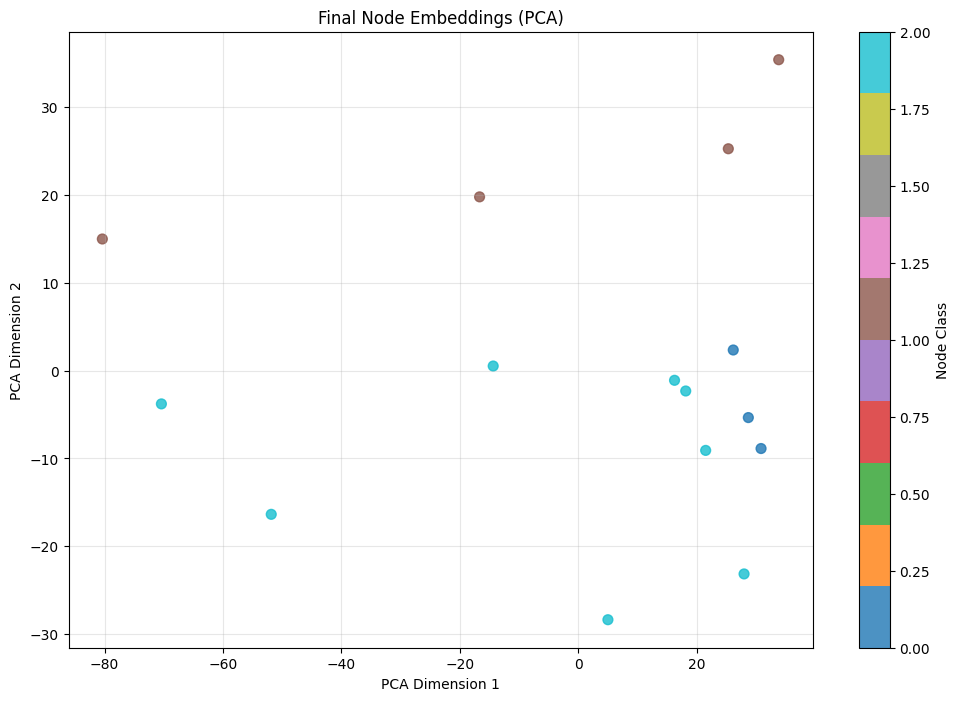

In [ ]:
loss_history = []
acc_history = []
epoch_history = []
parameter_history = []

data.train_mask = torch.ones(data.num_nodes, dtype=torch.bool)

for epoch in range(200):
  optimizer.zero_grad()
  out = model(data.x,data.edge_index)
  loss = nn.CrossEntropyLoss()(out[data.train_mask],data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  pred = out.argmax(dim=1)

  correct = pred[data.train_mask] == data.y[data.train_mask]
  train_acc = int(correct.sum()) / int(data.train_mask.sum())

  loss_history.append(loss.item())
  acc_history.append(train_acc)
  epoch_history.append(epoch)

  if (epoch ) % 10 == 0:
    params = {
        'epoch' : epoch,
        'loss' : loss.item(),
        'train_acc' : train_acc,
        'omega' : model.omega_params[0].item()
    }
    parameter_history.append(params)
  if epoch % 20 == 0:
    print(f"Epoch: {epoch}, Loss: {loss.item():.4f}, Train Accuracy: {train_acc:.4f}")
print("Training completed and we have the data available")
print(f"Loss History : {len(loss_history)}")
print(f"Accuracy History : {len(acc_history)}")
print(f"Epoch History : {len(epoch_history)}")
print(f"Parameter History : {len(parameter_history)}")

def plot_final_embeddings():
  model.eval()
  with torch.no_grad():
    embeddings = model(data.x,data.edge_index)
    embeddings = embeddings.cpu().numpy()
    labels = data.y.cpu().numpy()

    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                        c=labels, cmap='tab10', s=50, alpha=0.8)
    plt.colorbar(scatter, label='Node Class')
    plt.title('Final Node Embeddings (PCA)')
    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')
    plt.grid(True, alpha=0.3)
    plt.show()
plot_final_embeddings()

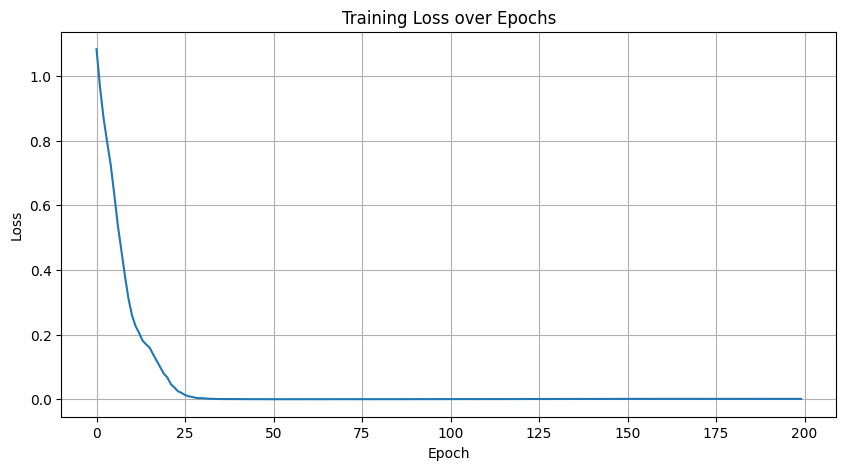

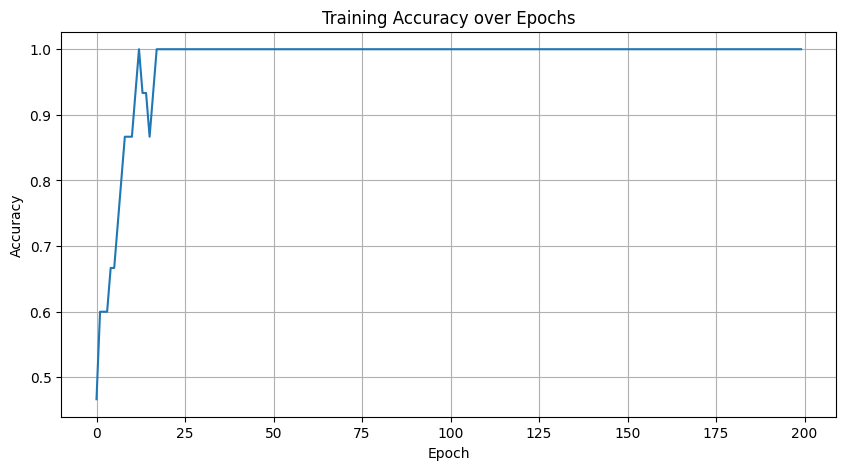

In [ ]:
# Plot the loss history
plt.figure(figsize=(10, 5))
plt.plot(epoch_history, loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

# Plot the accuracy history
plt.figure(figsize=(10, 5))
plt.plot(epoch_history, acc_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.grid(True)
plt.show()

#**Transferability test-1 $S_1^{N_1XN_2}$ → $S_2^{N_2XN_2}$**

In [ ]:
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

### Increasing layer count ###

N = 200
num_features = 8
num_classes = 3
G = nx.star_graph(N - 1)
loss = nn.MSELoss()
x = torch.randn(N,num_features)
y = torch.randint(0,num_classes,(N,))
for i in range(N):
  G.nodes[i]['x'] = x[i].tolist()
  G.nodes[i]['y'] = y[i].item()
data = from_networkx(G)
print(" *** Star Graph Data with Features and Classes ***")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of features per node: {data.x.shape[1]}")
print(f"Number of classes (max label + 1): {data.y.max().item() + 1}")
print("\nContents of the Data object:")
print(data)
data.train_mask = torch.ones(2000,dtype=torch.bool)
num_classes = data.y.max().item() + 1
model_1DFGNN = SpectralDuffingGNN(num_features=data.num_features,hidden_dim=32,num_classes=num_classes,num_layers=4)
optimizer1 = torch.optim.Adam(model_1DFGNN.parameters(),lr=0.01,weight_decay=5e-4)
model_1DFGNN.train()
print(model_1DFGNN)

model_2DFGNN = SpectralDuffingGNN(num_features=data.num_features,hidden_dim=64,num_classes=num_classes,num_layers=6)
optimizer2 = torch.optim.Adam(model_2DFGNN.parameters(),lr=0.01,weight_decay=5e-4)
model_2DFGNN.train()
print(model_2DFGNN)

def normalize_GSO(gso):
  eig_val,eig_vec = np.linalg.eig(gso)
  return gso/np.max(eig_val.real)
M = nx.adjacency_matrix(G)
M_tensor = torch.tensor(M.todense(),dtype=torch.float64)
dataDFGNN_gso = normalize_GSO(M_tensor)

 *** Star Graph Data with Features and Classes ***
Number of nodes: 200
Number of features per node: 8
Number of classes (max label + 1): 3

Contents of the Data object:
Data(x=[200, 8], edge_index=[2, 398], y=[200])
SpectralDuffingGNN(
  (layers): ModuleList(
    (0): DuffingGNNFilter(
      (linear_x): Linear(8, 32, bias=True)
      (linear_y): Linear(8, 32, bias=True)
      (linear_x_cubic): Linear(8, 32, bias=True)
    )
    (1-2): 2 x DuffingGNNFilter(
      (linear_x): Linear(32, 32, bias=True)
      (linear_y): Linear(32, 32, bias=True)
      (linear_x_cubic): Linear(32, 32, bias=True)
    )
    (3): DuffingGNNFilter(
      (linear_x): Linear(32, 3, bias=True)
      (linear_y): Linear(32, 3, bias=True)
      (linear_x_cubic): Linear(32, 3, bias=True)
    )
  )
  (omega_params): ParameterList(
      (0): Parameter containing: [torch.float32 of size 1]
      (1): Parameter containing: [torch.float32 of size 1]
      (2): Parameter containing: [torch.float32 of size 1]
      (3): P

In [ ]:
def generate_diffusion(gso,n_samples=2100,n_sources=10):
  n = gso.shape[0] ##number of nodes
  if not isinstance(gso,torch.Tensor):
    gso = torch.tensor(gso,dtype=torch.float64)
  z = torch.zeros((n_samples,n,11,1),dtype = torch.float64)
  for i in range(n_samples):
    sources = np.random.choice(n,n_sources,replace=False)
    # Cast torch.rand to float64 to match the dtype of z
    z[i,sources,0,0] = (torch.rand(n_sources) * 10).to(torch.float64)
  mu = torch.zeros(n,dtype=torch.float64)
  sigma = torch.eye(n,dtype=torch.float64) * 1e-3
  for t in range(10):
    noise = torch.distributions.multivariate_normal.MultivariateNormal(mu,sigma).sample((n_samples,))
    z[:,:,t+1] = torch.matmul(gso,z[:,:,t]) + noise.unsqueeze(-1)
  z = z.transpose(1,2)
  return z.squeeze()

def data_from_diffusion(z):
  z = z[torch.randperm(z.shape[0])]
  y = z[:,0,:].unsqueeze(1)
  x = torch.zeros_like(y)
  x = z[:,4,:]
  return x.squeeze(),y.squeeze()

### Checking in loss history
loss_history1 = []
loss_history2 = []
data.train_mask = torch.ones(data.num_nodes, dtype=torch.bool)
criterion = nn.CrossEntropyLoss()

for epoch in range(200):
  optimizer1.zero_grad()
  optimizer2.zero_grad()
  out1 = model_1DFGNN(data.x,data.edge_index)
  out2 = model_2DFGNN(data.x,data.edge_index)
  loss1 = criterion(out1[data.train_mask],data.y[data.train_mask])
  loss2 = criterion(out2[data.train_mask],data.y[data.train_mask])
  loss1.backward()
  loss2.backward()
  optimizer1.step()
  optimizer2.step()
  loss_history1.append(loss1.item())
  loss_history2.append(loss2.item())
  if epoch % 20 == 0:
    print(f"Epoch: {epoch}, Loss1: {loss1.item():.4f}, Loss2: {loss2.item():.4f}")
print("Training completed and we have the data available")

Epoch: 0, Loss1: 1.0983, Loss2: 1.1005
Epoch: 20, Loss1: 1.0693, Loss2: 1.0702
Epoch: 40, Loss1: 1.0691, Loss2: 1.0692
Epoch: 60, Loss1: 1.0691, Loss2: 1.0691
Epoch: 80, Loss1: 1.0691, Loss2: 1.0691
Epoch: 100, Loss1: 1.0691, Loss2: 1.0691
Epoch: 120, Loss1: 1.0691, Loss2: 1.0691
Epoch: 140, Loss1: 1.0691, Loss2: 1.0691
Epoch: 160, Loss1: 1.0691, Loss2: 1.0691
Epoch: 180, Loss1: 1.0691, Loss2: 1.0691
Training completed and we have the data available


Loss History 1 for DuffingGNN-1 : 1.069058
Loss History 2 for DuffingGNN-2 : 1.069049


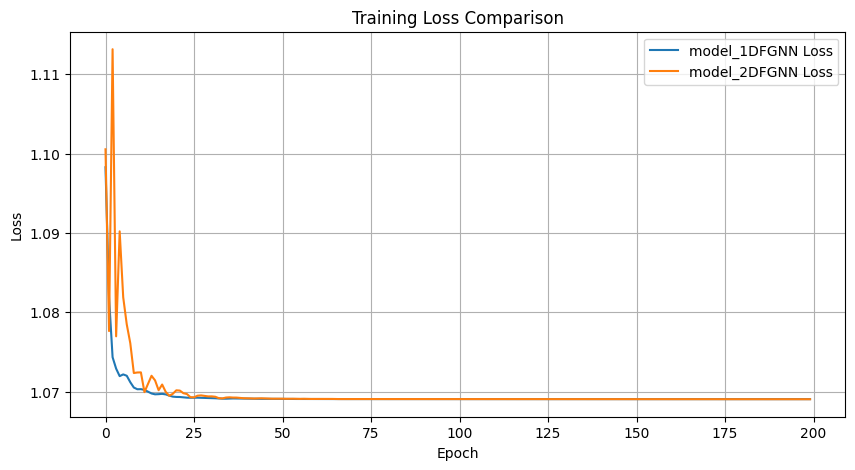

In [ ]:
print(f"Loss History 1 for DuffingGNN-1 : {loss1:.6f}")
print(f"Loss History 2 for DuffingGNN-2 : {loss2:.6f}")
plt.figure(figsize=(10, 5))
plt.plot(range(len(loss_history1)), loss_history1, label='model_1DFGNN Loss')
plt.plot(range(len(loss_history2)), loss_history2, label='model_2DFGNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)
plt.show()

**GAT**

In [ ]:
zeroTolerance = 1e-9
infiniteNumber = 1e9

def attentionGSO(x,a,W,S,negative_slope=0.2):
  ## x (torch.tensor) = input shape :- batch size x input features x number of nodes
  ## a(torch.tensor)  = mixing      :- number heads x edge features x 2*outputfeatures
  ## W(torch.tensor)  = linear parameter :- number heads x edge features x output features x input features
  ## S (torch.tensor) = graph shift operator :- edge features x number of nodes

  B = x.shape[0] #batch size
  G = x.shape[1] #input feaures
  N = x.shape[2] #number of nodes
  P = a.shape[0] #number of heads
  E = a.shape[1] #edge features
  assert W.shape[0] == P
  assert W.shape[1] == E
  F = W.shape[2]
  assert a.shape[2] == int(2*F)
  G = W.shape[3]
  assert S.shape[0] == E
  assert S.shape[1] == S.shape[2] == N
  ## adding ones of GSO at all edge features so that nodes have access to themselves
  S = S + torch.eye(N).reshape([-1,N,N]).repeat(E,1,1).to(S.device)
  x = x.reshape([B, 1, 1, G, N])
  W = W.reshape([1, P, E, F, G])
  Wx = torch.matmul(W,x) ## B x P x E x F x N
  a1 = torch.index_select(a, 2 ,torch.arange(F).to(x.device)) ## P x E x F
  a2 = torch.index_select(a, 2 ,torch.arange(F,2*F).to(x.device)) ## P x E x F
  a1Wx = torch.matmul(a1.reshape([1,P,E,1,F]),Wx)
  a2Wx = torch.matmul(a2.reshape([1,P,E,1,F]),Wx)
  aWx = a1Wx + a2Wx.permute([0, 1, 2, 4, 3])
  eij = nn.functional.leaky_relu(aWx,negative_slope=negative_slope)
  maskEdges = torch.sum(torch.abs(S.data),dim=0)
  maskEdges = (maskEdges > zeroTolerance).type(x.dtype)
  infinityMask = (1 - maskEdges) * infiniteNumber
  aij = nn.functional.softmax(eij*maskEdges - infinityMask,dim=4)
  return aij * maskEdges


#**Graph attnetion mechanicsm based GSO**

In [ ]:
## dummy parameters ##
N = 15
num_features = 8
hidden_dim = 32
btach_size = 1
num_heads = 4
edge_features = 1
num_classes = 3
def normalize_GSO(gso):
  eig_val,eig_vec = np.linalg.eig(gso)
  return gso/np.max(eig_val.real)
import networkx as nx
from torch_geometric.utils import from_networkx
G = nx.star_graph(N - 1)
x = torch.randn(N,num_features)
y = torch.randint(0,num_classes,(N,))
for i in range(N):
  G.nodes[i]['x'] = x[i].tolist()
  G.nodes[i]['y'] = y[i].item()
data = from_networkx(G)
data.train_mask = torch.ones(data.num_nodes, dtype=torch.bool)
num_classes = data.y.max().item() + 1
model = SpectralDuffingGNN(num_features=data.num_features,hidden_dim=32,num_classes=num_classes,num_layers=4)
optimizer = torch.optim.Adam(model.parameters(),lr=0.01,weight_decay=5e-4)
model.train()
print(model)

M = nx.adjacency_matrix(G)
M_tensor = torch.tensor(M.todense(),dtype=torch.float)
data_gso = normalize_GSO(M_tensor)

### developing the input arguments ###
x = torch.randn(btach_size,num_features,N)
a = torch.randn(num_heads,edge_features,2*hidden_dim)
W = torch.randn(num_heads,edge_features,hidden_dim,num_features)
S = data_gso.reshape(edge_features,N,N)

print(f"input tensor 'x' shape is :- {x.shape}")
print(f"mixing tensor'a' shape is :- {a.shape}")
print(f"linear tensor 'W' shape is :- {W.shape}")
print(f"graph shift tensor shape is :- {S.shape}")

output = attentionGSO(x,a,W,S)
print("\n--- The output matrix for the GAT operator is ___\n")
print(output)

SpectralDuffingGNN(
  (layers): ModuleList(
    (0): DuffingGNNFilter(
      (linear_x): Linear(8, 32, bias=True)
      (linear_y): Linear(8, 32, bias=True)
      (linear_x_cubic): Linear(8, 32, bias=True)
    )
    (1-2): 2 x DuffingGNNFilter(
      (linear_x): Linear(32, 32, bias=True)
      (linear_y): Linear(32, 32, bias=True)
      (linear_x_cubic): Linear(32, 32, bias=True)
    )
    (3): DuffingGNNFilter(
      (linear_x): Linear(32, 3, bias=True)
      (linear_y): Linear(32, 3, bias=True)
      (linear_x_cubic): Linear(32, 3, bias=True)
    )
  )
  (omega_params): ParameterList(
      (0): Parameter containing: [torch.float32 of size 1]
      (1): Parameter containing: [torch.float32 of size 1]
      (2): Parameter containing: [torch.float32 of size 1]
      (3): Parameter containing: [torch.float32 of size 1]
  )
)
input tensor 'x' shape is :- torch.Size([1, 8, 15])
mixing tensor'a' shape is :- torch.Size([4, 1, 64])
linear tensor 'W' shape is :- torch.Size([4, 1, 32, 8])
grap

#**Hybrid ARMA-Duffing GNN**

**Functionals + Filters**

In [9]:
import torch
import torch.nn as nn

def LSIGF(h, S, x, b=None):
  F = h.shape[0] ##out features
  E = h.shape[1] ## edge features
  K = h.shape[2] ## inverse polynomial order
  G = h.shape[3] ## input features
  assert S.shape[0] == E
  N = S.shape[1]
  assert S.shape[2] == N
  B = x.shape[0]
  assert x.shape[1] == G
  assert x.shape[2] == N

  x = x.reshape([B, 1, G, N])
  S = S.reshape([1, E, N, N])
  z = x.reshape([B, 1, 1, G, N]).repeat([1, E, 1, 1, 1])
  for k in range(1,K):
    x = torch.matmul(x,S)
    xS = x.reshape([B, E, 1, G, N])
    z = torch.cat((z,xS),dim=2)
  y = torch.matmul(z.permute(0,4,1,2,3).reshape([B,N,E*K*G]),
                   h.reshape([F, E*K*G]).permute(1,0)).permute(0,2,1)
  if b is not None:
    y = y + b.reshape([1, F, 1])
  return y

def jARMA(psi, varphi, phi, S, x, b=None, tMax=5):
    F = psi.shape[0]  # out features = 64
    E = psi.shape[1]  # edge features = 1
    P = psi.shape[2]  # inverse polynomial order = 2
    G = psi.shape[3]  # input features = 8

    assert varphi.shape[0] == F
    assert varphi.shape[1] == E
    assert varphi.shape[2] == P
    assert varphi.shape[3] == G
    assert phi.shape[0] == F
    assert phi.shape[1] == E
    assert phi.shape[3] == G

    B = x.shape[0]  # batch size = 1
    assert x.shape[1] == G  # 8
    N = x.shape[2]  # number of nodes = 200
    assert S.shape[0] == E  # 1
    assert S.shape[1] == S.shape[2] == N  # 200

    ## Making the Stilde and Sbar
    Stilde = torch.empty(0).to(S.device)
    DiagS = torch.empty(0).to(S.device)

    for e in range(E):
        thisS = torch.index_select(S, 0, torch.tensor(e).to(S.device)).squeeze(0)
        thisDiagS = torch.diag(torch.diag(thisS))
        DiagOffS = (thisS - thisDiagS).unsqueeze(0)
        Stilde = torch.cat((Stilde, DiagOffS), dim=0)
        DiagS = torch.cat((DiagS, thisDiagS.unsqueeze(0)), dim=0)

    I = torch.eye(N).reshape([1, 1, 1, 1, N, N]).to(S.device)
    psiI = psi.reshape([F, E, P, G, 1, 1]) * I
    DiagS = DiagS.reshape([1, E, 1, 1, N, N])
    Sbar = DiagS - psiI

    # Handle numerical stability for SbarInv
    offDiagonalOnes = (torch.ones(N, N) - torch.eye(N)).to(Sbar.device)
    Sbar_safe = Sbar + offDiagonalOnes

    # Compute inverse only for diagonal elements
    eye_mask = torch.eye(N).bool().to(Sbar.device)
    SbarInv = torch.zeros_like(Sbar_safe)

    for f in range(F):
        for e in range(E):
            for p in range(P):
                for g in range(G):
                    Sbar_diag = Sbar_safe[f, e, p, g]
                    inv_diag = torch.where(eye_mask, 1.0 / Sbar_diag, torch.eye(N).to(Sbar.device))
                    SbarInv[f, e, p, g] = inv_diag

    SbarInvX = torch.matmul(SbarInv.reshape([1, F, E, P, G, N, N]),
                          x.reshape([B, 1, 1, 1, G, N, 1])).squeeze(6)

    SbarInvStilde = torch.matmul(SbarInv, Stilde.reshape([1, E, 1, 1, N, N]))
    H3x = LSIGF(phi, S, x)

    ## Combining all the filters
    z = SbarInvX.reshape([B, F, E, 1, P, G, N])
    y = x.reshape([B, 1, 1, 1, G, N, 1])
    x1 = SbarInvX.unsqueeze(6)

    for tau in range(1, tMax+1):
        x1 = torch.matmul(SbarInvStilde.unsqueeze(0), x1)
        z = torch.cat((z, x1.squeeze(6).unsqueeze(3)), dim=3)
        y = torch.matmul(SbarInvStilde.unsqueeze(0), y)

    thisCoeff = torch.tensor([(-1.)**k for k in range(tMax + 1)], device=x.device, dtype=x.dtype)
    thisCoeff = thisCoeff.reshape([1, 1, 1, tMax + 1, 1])
    varphi_expanded = varphi.unsqueeze(3)  # [64, 1, 2, 1, 8]
    varphi_expanded = varphi_expanded.expand(-1, -1, -1, tMax + 1, -1)  # [64, 1, 2, 6, 8]

    thisCoeff = thisCoeff.expand(F, E, P, -1, G)  # [64, 1, 2, 6, 8]
    thisCoeff = thisCoeff * varphi_expanded
    z = z.permute(0, 6, 1, 2, 3, 4, 5)
    z_flat = z.reshape(B, N, -1)
    thisCoeff_flat = thisCoeff.permute(1, 2, 3, 4, 0)  # [1, 2, 6, 8, 64]
    thisCoeff_flat = thisCoeff_flat.reshape(-1, F)

    thisCoeff_flat = thisCoeff_flat.repeat_interleave(F, dim=0)  # [6144, 64]

    # Now matrix multiplication: [1, 200, 6144] @ [6144, 64] = [1, 200, 64]
    H1x = torch.matmul(z_flat, thisCoeff_flat)  # [1, 200, 64]
    H1x = H1x.permute(0, 2, 1)  # [1, 64, 200]

    # Compute H2x
    y = torch.matmul(SbarInvStilde.unsqueeze(0), y).squeeze(6)  # [1, 64, 1, 2, 8, 200]
    H2x = -y if (tMax % 2 == 0) else y
    H2x = torch.sum(H2x, dim=(2, 3, 4))  # Sum over E, P, G: [1, 64, 200]

    u = H1x + H2x + H3x  # [1, 64, 200]

    if b is not None:
        u = u + b.reshape([1, F, 1])  # [1, 64, 1]

    return u
import math
class GraphFilterARMA(nn.Module):
  def __init__(self,G,F,P,K,E=1,bias=True,tMax = 5):
    super().__init__() ##initializing the parent
    self.G = G
    self.F = F
    self.P = P
    self.K = K
    self.E = E
    self.tMax = tMax
    self.S = None ## GSO to be assigned lateron
    self.N = None

    # Creation of Parameters
    self.inverseWeight = nn.parameter.Parameter(torch.Tensor(F,E,P,G))
    self.directWeight  = nn.parameter.Parameter(torch.Tensor(F,E,P,G))
    self.filterWeight  = nn.parameter.Parameter(torch.Tensor(F,E,K,G))
    if bias:
      self.bias = nn.parameter.Parameter(torch.Tensor(F,1))
    else:
      self.register_parameter('bias',None)
    self.reset_parameters()

  def reset_parameters(self):
    stdv = 1. / math.sqrt(self.G * self.P)
    self.inverseWeight.data.uniform_(1.+1./stdv, 1.+2./stdv)
    self.directWeight.data.uniform_(-stdv,stdv)
    self.filterWeight.data.uniform_(-stdv,stdv)
    if self.bias is not None:
      self.bias.data.uniform_(-stdv,stdv)

  def addGSO(self,S):
    assert len(S.shape) == 3
    assert S.shape[0] == self.E
    self.N = S.shape[1]
    assert S.shape[2] == self.N
    self.S = S

  def forward(self,x):
    B = x.shape[0]
    F = x.shape[1]
    Nin = x.shape[2]
    ## adding zero padding
    if Nin < self.N:
      x = torch.cat((x , torch.zeros(B,F,self.N-Nin).type(x.dtype).to(x.device)),dim = 2)
    u = jARMA(self.inverseWeight,self.directWeight,self.filterWeight,self.S, x, b = self.bias, tMax=self.tMax)
    if Nin < self.N:
      u = torch.index_select(u, 2, torch.arange(Nin).to(u.device)) ## removing the unnecessary padding
    return u

  def extra_repr(self):
    repString += "in features=%d" % self.G
    repString += "out features=%d" % self.F
    repString += "denominator taps=%d" % self.P
    repString += "residue taps=%d" % self.K
    repString += "edge Features=%d"% self.E
    repString += "bias=%r" % (self.bias is not None)
    if self.S is not None:
      repString += "GSO stored"
    else:
      repString += "GSO not stored"
    return repString

#**Graph Tools**

In [10]:
## Determining the permutation by degree ##
def permDegree(S):
  assert len(S.shape) == 2 or len(S.shape) == 3
  scalarWeights = False
  if len(S.shape) == 2:
    assert S.shape[0] == S.shape[1]
    S = S.reshape([1, S.shape[0], S.shape[1]])
    scalarWeights = True
  else:
    assert S.shape[1] == S.shape[2]
    scalarWeights = False

  d = np.sum(np.sum(S, axis=1),axis = 0) ## computing the degree
  order = np.argsort(d)
  order = np.flip(order,0)
  S = S[:,order,:][:,:,order]
  if scalarWeights:
    S = S.reshape([S.shape[1],S.shape[2]])
  return S,order.tolist()

def permIdentity(S):
  assert len(S.shape) == 2 or len(S.shape) == 3
  if len(S.shape) == 2:
    assert S.shape[0] == S.shape[1]
    S = S.reshape([1, S.shape[0] , S.shape[1]])
    scalarWeights = True
  else:
    assert S.shape[1] == S.shape[2]
    scalarWeights = False
  N = S.shape[1]
  order = np.arange(N)
  if scalarWeights:
    S = S.reshape([N , N])
  return S, order.tolist()

def changeDataType(x, dataType):
  if 'dtype' in dir(x):
    varType = x.dtype
  if 'numpy' in repr(dataType):
    if 'torch' in repr(varType):
      x = x.cpu().numpy().astype(dataType)
    elif 'numpy'in repr(type(x)):
      x = x.astype(dataType)
  elif 'torch' in repr(dataType):
    if 'torch' in repr(varType):
      x = x.type(dataType)
    elif 'numpy' in repr(type(x)):
      x = torch.tensor(x, dtype = dataType)
  return x

#**Final Architecture**

In [11]:
import torch
import torch.nn as nn
import numpy as np
import torch_geometric.nn as pyg_nn
from torch_geometric.utils import degree
from torch_scatter import scatter_add

class DuffingGNNFilter(nn.Module):
  def __init__(self,in_channels,out_channels,C=0.2,delta=0.5,omega=1.0):
    super().__init__()
    self.C = C
    self.delta = delta
    self.omega = omega
    self.a = nn.Parameter(torch.randn(1))

    self.linear_x = pyg_nn.Linear(in_channels,out_channels)
    self.linear_y = pyg_nn.Linear(in_channels,out_channels)
    self.linear_x_cubic = pyg_nn.Linear(in_channels,out_channels) ## for the cubic term

  def forward(self,x,edge_index,edge_weight=None):
    row,col = edge_index
    deg = degree(row, x.size(0), dtype = x.dtype)
    deg_inv = 1.0/deg.clamp_min(1)

    linear_x_out = self.linear_x(x)
    linear_y_out = self.linear_y(x)
    linear_x_cubic_out = self.linear_x_cubic(x**3)

    if edge_weight is None:
      edge_weight = torch.ones(edge_index.size(1),device=x.device)

    weighted_linear_y_out = linear_y_out[col] * edge_weight.view(-1 , 1) * deg_inv[col].view(-1 , 1)
    Lx = scatter_add(weighted_linear_y_out,row,dim=0, dim_size = x.size(0))

    coupling = -self.C * Lx
    x_dot = linear_y_out + coupling
    y_dot = linear_x_out - linear_x_cubic_out - self.delta * linear_y_out + self.a * torch.sin(self.omega * torch.arange(x.size(0) , device = x.device)).unsqueeze(-1) ## Assuming for correct broadcast
    dt = 0.1
    x_new = linear_x_out + dt * x_dot
    y_new = linear_y_out + dt * y_dot
    return x_new,y_new

class ARMAFilterGNN(nn.Module):
    def __init__(self, dimNodeSignals, nDenominatorTaps, nResidueTaps, bias=True,
                 nonlinearity=nn.ReLU, nSelectNodes=None, poolingFunction=None,
                 poolingSize=None, dimLayersMLP=None, GSO=None, order=None, tMax=5):
        super().__init__()
        assert len(dimNodeSignals) == len(nDenominatorTaps) + 1
        assert len(dimNodeSignals) == len(nResidueTaps) + 1

        self.L = len(nResidueTaps)  # number of layers
        self.F = dimNodeSignals  # Features per layer
        self.P = nDenominatorTaps  # Denominator taps
        self.K = nResidueTaps  # Residue taps
        self.bias = bias
        self.tMax = tMax
        self.nonlinearity = nonlinearity

        nSelectNodes = nSelectNodes if nSelectNodes is not None else [dimNodeSignals[i+1] for i in range(self.L)]
        poolingFunction = poolingFunction if poolingFunction is not None else lambda n_in, n_out, alpha: nn.Identity()
        poolingSize = poolingSize if poolingSize is not None else [1] * self.L
        dimLayersMLP = dimLayersMLP if dimLayersMLP is not None else []

        # Process GSO
        if GSO is not None:
            if len(GSO.shape) == 2:
                GSO = GSO.unsqueeze(0)  # Add edge dimension
            self.E = GSO.shape[0]  # number of edges
            self.N = GSO.shape[1]  # number of nodes
            if order is not None:
                self.permFunction = eval('perm' + order)
            else:
                self.permFunction = permIdentity
            self.S, self.order = self.permFunction(GSO)
        else:
            self.S = None
            self.E = 1
            self.N = dimNodeSignals[0]

        self.arma_layers = nn.ModuleList()
        for l in range(self.L):
            # Graph filter layer
            gf_layer = GraphFilterARMA(self.F[l], self.F[l+1], self.P[l], self.K[l],
                                     self.E, self.bias, self.tMax)
            if self.S is not None:
                gf_layer.addGSO(self.S)

            nonlinear_layer = self.nonlinearity()

            pool_layer = poolingFunction(self.N, nSelectNodes[l], poolingSize[l])
            if hasattr(pool_layer, 'addGSO') and self.S is not None:
                pool_layer.addGSO(self.S)

            self.arma_layers.extend([gf_layer, nonlinear_layer, pool_layer])

        self.mlp_layers = nn.ModuleList()
        if dimLayersMLP:
            dimInputMLP = nSelectNodes[-1] * self.F[-1] if nSelectNodes else self.N * self.F[-1]
            self.mlp_layers.append(nn.Linear(dimInputMLP, dimLayersMLP[0], bias=self.bias))
            for i in range(len(dimLayersMLP)-1):
                self.mlp_layers.append(self.nonlinearity())
                self.mlp_layers.append(nn.Linear(dimLayersMLP[i], dimLayersMLP[i+1], bias=self.bias))

    def forward(self, x):
        for i in range(0, len(self.arma_layers), 3):
            x = self.arma_layers[i](x)  # Graph filter
            x = self.arma_layers[i+1](x)  # Nonlinearity
            x = self.arma_layers[i+2](x)  # Pooling

        if self.mlp_layers:
            x = x.reshape(x.shape[0], -1)
            for layer in self.mlp_layers:
                x = layer(x)

        return x

    def addGSO(self, GSO):
        """Update GSO for all layers"""
        if len(GSO.shape) == 2:
            GSO = GSO.unsqueeze(0)
        self.S = GSO
        self.E = GSO.shape[0]
        self.N = GSO.shape[1]

        for i in range(0, len(self.arma_layers), 3):
            if hasattr(self.arma_layers[i], 'addGSO'):
                self.arma_layers[i].addGSO(self.S)
            if hasattr(self.arma_layers[i+2], 'addGSO'):
                self.arma_layers[i+2].addGSO(self.S)


#**Evaluation Block - 1**

In [13]:
import torch.optim as optim
import torch.nn as nn
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import degree
from torch_scatter import scatter_add
import torch_geometric.nn as pyg_nn

# Create the star graph data
N = 20
num_features = 8
num_classes = 7

G = nx.star_graph(N - 1)
x = torch.randn(N, num_features)
y = torch.randint(0, num_classes, (N,))

# Create edge_index from networkx graph
edge_index = torch.tensor(list(G.edges)).t().contiguous()

# Create PyG data object
data = Data(x=x, edge_index=edge_index, y=y)

print(" *** Star Graph Data with Features and Classes ***")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of features per node: {data.x.shape[1]}")
print(f"Number of classes (max label + 1): {data.y.max().item() + 1}")
print("\nContents of the Data object:")
print(data)

### Creating dummy masks for training testing and validation ###
if not hasattr(data, 'train_mask'):
    data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.train_mask[:int(data.num_nodes * 0.6)] = True
if not hasattr(data, 'val_mask'):
    data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.val_mask[int(data.num_nodes * 0.6):int(data.num_nodes * 0.8)] = True
if not hasattr(data, 'test_mask'):
    data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.test_mask[int(data.num_nodes * 0.8):] = True

def create_gso_from_edge_index(edge_index, num_nodes):
    # Create adjacency matrix
    adj = torch.zeros(num_nodes, num_nodes)
    adj[edge_index[0], edge_index[1]] = 1

    # Add self-loops and normalize
    adj = adj + torch.eye(num_nodes)
    row_sum = adj.sum(dim=1)
    deg_inv_sqrt = torch.pow(row_sum, -0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    deg_inv_sqrt = torch.diag(deg_inv_sqrt)

    # Normalized adjacency matrix as GSO
    gso = deg_inv_sqrt @ adj @ deg_inv_sqrt
    return gso.unsqueeze(0)  # Add edge dimension [1, N, N]

# Create GSO from the graph data
num_nodes = data.num_nodes
gso = create_gso_from_edge_index(data.edge_index, num_nodes)

class DuffingGNNFilter(nn.Module):
    def __init__(self, in_channels, out_channels, C=0.2, delta=0.5, omega=1.0):
        super().__init__()
        self.C = C
        self.delta = delta
        self.omega = omega
        self.a = nn.Parameter(torch.randn(1))

        self.linear_x = pyg_nn.Linear(in_channels, out_channels)
        self.linear_y = pyg_nn.Linear(in_channels, out_channels)
        self.linear_x_cubic = pyg_nn.Linear(in_channels, out_channels)  # for the cubic term

    def forward(self, x, edge_index, edge_weight=None):
        # Handle different input formats
        if len(x.shape) == 3:
            # [batch_size, features, nodes] -> [nodes, features]
            batch_size, features, nodes = x.shape
            x_2d = x.permute(0, 2, 1).reshape(-1, features)
        else:
            # [features, nodes] -> [nodes, features]
            x_2d = x.permute(1, 0) if x.shape[0] != data.num_nodes else x

        row, col = edge_index
        deg = degree(row, x_2d.size(0), dtype=x_2d.dtype)
        deg_inv = 1.0 / deg.clamp_min(1)

        linear_x_out = self.linear_x(x_2d)
        linear_y_out = self.linear_y(x_2d)
        linear_x_cubic_out = self.linear_x_cubic(x_2d**3)

        if edge_weight is None:
            edge_weight = torch.ones(edge_index.size(1), device=x_2d.device)

        weighted_linear_y_out = linear_y_out[col] * edge_weight.view(-1, 1) * deg_inv[col].view(-1, 1)
        Lx = scatter_add(weighted_linear_y_out, row, dim=0, dim_size=x_2d.size(0))

        coupling = -self.C * Lx
        x_dot = linear_y_out + coupling
        y_dot = linear_x_out - linear_x_cubic_out - self.delta * linear_y_out + self.a * torch.sin(self.omega * torch.arange(x_2d.size(0), device=x_2d.device)).unsqueeze(-1)

        dt = 0.1
        x_new = linear_x_out + dt * x_dot
        y_new = linear_y_out + dt * y_dot

        # Convert back to original format if needed
        if len(x.shape) == 3:
            x_new = x_new.reshape(batch_size, nodes, -1).permute(0, 2, 1)
            y_new = y_new.reshape(batch_size, nodes, -1).permute(0, 2, 1)

        return x_new, y_new

class HybridARMADuffingGNN(nn.Module):
    def __init__(self, dimNodeSignals, nResidueTaps, nDenominatorTaps,
                 hidden_dim, num_classes, duffing_layers=2, bias=True,
                 nonlinearity=nn.ReLU, nSelectNodes=None, poolingFunction=None,
                 poolingSize=None, dimLayersMLP=None, GSO=None, order=None, tMax=5):
        super().__init__()

        # ARMA part
        self.arma_gnn = ARMAFilterGNN(
            dimNodeSignals=dimNodeSignals,
            nDenominatorTaps=nDenominatorTaps,
            nResidueTaps=nResidueTaps,
            bias=bias,
            nonlinearity=nonlinearity,
            nSelectNodes=nSelectNodes,
            poolingFunction=poolingFunction,
            poolingSize=poolingSize,
            dimLayersMLP=dimLayersMLP,
            GSO=GSO,
            order=order,
            tMax=tMax
        )

        # Duffing part
        self.duffing_layers = nn.ModuleList()

        # ARMA output will be [batch_size, features, nodes]
        arma_output_dim = dimNodeSignals[-1] if not dimLayersMLP else dimLayersMLP[-1]

        for _ in range(duffing_layers):
            self.duffing_layers.append(DuffingGNNFilter(arma_output_dim, hidden_dim))
            arma_output_dim = hidden_dim

        self.output_layer = DuffingGNNFilter(hidden_dim, num_classes)

    def forward(self, x, edge_index):
        # ARMA processing
        x = self.arma_gnn(x)  # [batch_size, features, nodes]

        # Duffing processing - use only x output from Duffing equations
        for duffing_layer in self.duffing_layers:
            x, _ = duffing_layer(x, edge_index)  # Using only the x output
            x = torch.relu(x)

        x, _ = self.output_layer(x, edge_index)
        if len(x.shape) == 3:
            x = x.permute(0, 2, 1)  # [batch_size, nodes, features]
        else:
            x = x.permute(1, 0)  # [nodes, features]

        return x

dimNodeSignals = [8, 64, 32]
nResidueTaps = [3, 2]
nDenominatorTaps = [2, 1]
hidden_dim = 32
num_classes = 7
duffing_layers = 2

model = HybridARMADuffingGNN(
    dimNodeSignals=dimNodeSignals,
    nResidueTaps=nResidueTaps,
    nDenominatorTaps=nDenominatorTaps,
    hidden_dim=hidden_dim,
    num_classes=num_classes,
    duffing_layers=duffing_layers,
    bias=True,
    GSO=gso
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()

    x_3d = data.x.unsqueeze(0).permute(0, 2, 1)

    out = model(x_3d, data.edge_index)

    if len(out.shape) == 3:
        out = out.squeeze(0)

    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(mask):
    model.eval()
    with torch.no_grad():
        x_3d = data.x.unsqueeze(0).permute(0, 2, 1)
        out = model(x_3d, data.edge_index)

        if len(out.shape) == 3:
            out = out.squeeze(0)

        pred = out[mask].argmax(dim=1)
        correct = pred == data.y[mask]
        acc = int(correct.sum()) / int(mask.sum())
        return acc

# Training loop
epochs = 100
train_losses = []
val_accuracies = []
for epoch in range(epochs):
    loss = train()
    train_losses.append(loss)
    val_acc = evaluate(data.val_mask)
    val_accuracies.append(val_acc)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}')

print("Training Complete")
test_acc = evaluate(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

 *** Star Graph Data with Features and Classes ***
Number of nodes: 20
Number of features per node: 8
Number of classes (max label + 1): 7

Contents of the Data object:
Data(x=[20, 8], edge_index=[2, 19], y=[20])
Epoch 10/100, Loss: 1.9167, Val Acc: 0.0000
Epoch 20/100, Loss: 1.8044, Val Acc: 0.2500
Epoch 30/100, Loss: 1.5887, Val Acc: 0.2500
Epoch 40/100, Loss: 1.2835, Val Acc: 0.2500
Epoch 50/100, Loss: 0.8784, Val Acc: 0.2500
Epoch 60/100, Loss: 0.4751, Val Acc: 0.2500
Epoch 70/100, Loss: 0.2155, Val Acc: 0.2500
Epoch 80/100, Loss: 0.0833, Val Acc: 0.5000
Epoch 90/100, Loss: 0.0269, Val Acc: 0.2500
Epoch 100/100, Loss: 0.0101, Val Acc: 0.5000
Training Complete
Test Accuracy: 0.0000


#**Training Output - 1**

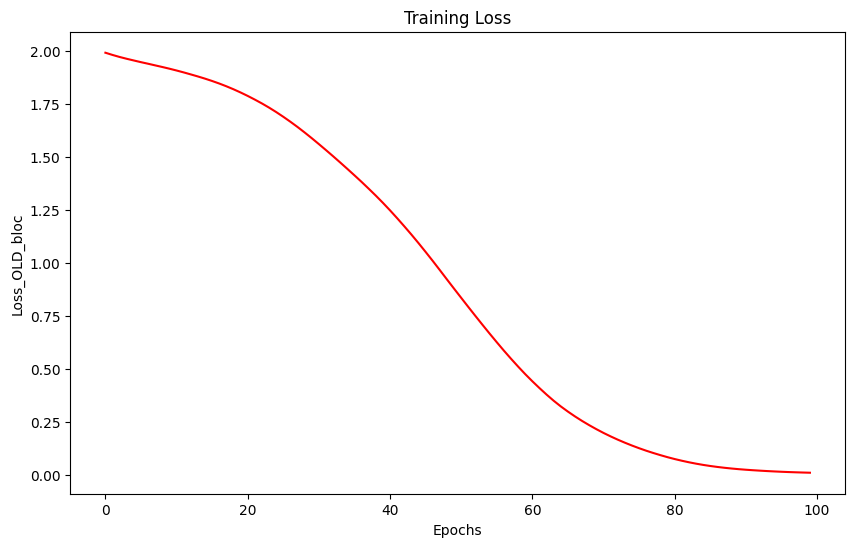

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(train_losses,color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss_OLD_bloc")
plt.title("Training Loss")
plt.savefig("loss_Layer_OLD.png")
plt.show()

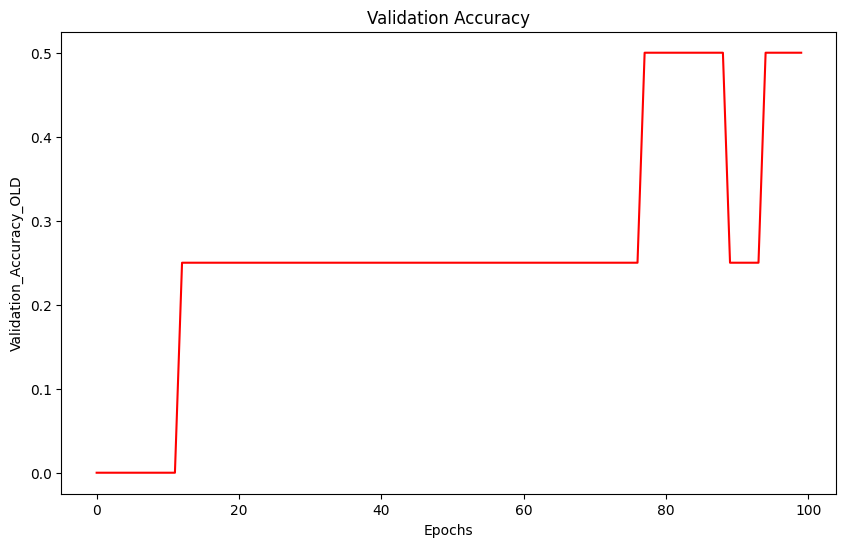

In [15]:
plt.figure(figsize=(10,6))
plt.plot(val_accuracies,color='red')
plt.xlabel("Epochs")
plt.ylabel("Validation_Accuracy_OLD")
plt.title("Validation Accuracy")
plt.savefig("Validation_layer_OLD.png")
plt.show()

#**Evaluation Block - 2 (Updated)**

In [6]:
import torch.optim as optim
import torch.nn as nn
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import degree
from torch_scatter import scatter_add
import torch_geometric.nn as pyg_nn

# Create the star graph data
N = 20
num_features = 8
num_classes = 7

G = nx.star_graph(N - 1)
x = torch.randn(N, num_features)
y = torch.randint(0, num_classes, (N,))

# Create edge_index from networkx graph
edge_index = torch.tensor(list(G.edges)).t().contiguous()

# Create PyG data object
data = Data(x=x, edge_index=edge_index, y=y)

print(" *** Star Graph Data with Features and Classes ***")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of features per node: {data.x.shape[1]}")
print(f"Number of classes (max label + 1): {data.y.max().item() + 1}")
print("\nContents of the Data object:")
print(data)

### Creating dummy masks for training testing and validation ###
if not hasattr(data, 'train_mask'):
    data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.train_mask[:int(data.num_nodes * 0.6)] = True
if not hasattr(data, 'val_mask'):
    data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.val_mask[int(data.num_nodes * 0.6):int(data.num_nodes * 0.8)] = True
if not hasattr(data, 'test_mask'):
    data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.test_mask[int(data.num_nodes * 0.8):] = True

def create_gso_from_edge_index(edge_index, num_nodes):
    # Create adjacency matrix
    adj = torch.zeros(num_nodes, num_nodes)
    adj[edge_index[0], edge_index[1]] = 1

    # Add self-loops and normalize
    adj = adj + torch.eye(num_nodes)
    row_sum = adj.sum(dim=1)
    deg_inv_sqrt = torch.pow(row_sum, -0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    deg_inv_sqrt = torch.diag(deg_inv_sqrt)

    # Normalized adjacency matrix as GSO
    gso = deg_inv_sqrt @ adj @ deg_inv_sqrt
    return gso.unsqueeze(0)  # Add edge dimension [1, N, N]

# Creating GSO from the graph data
num_nodes = data.num_nodes
gso = create_gso_from_edge_index(data.edge_index, num_nodes)

class DuffingGNNFilter(nn.Module):
    def __init__(self, in_channels, out_channels, C=0.2, delta=0.5, omega=1.0):
        super().__init__()
        self.C = C
        self.delta = delta
        self.omega = omega
        self.a = nn.Parameter(torch.randn(1))

        self.linear_x = pyg_nn.Linear(in_channels, out_channels)
        self.linear_y = pyg_nn.Linear(in_channels, out_channels)
        self.linear_x_cubic = pyg_nn.Linear(in_channels, out_channels)  # for the cubic term

    def forward(self, x, edge_index, edge_weight=None):
        # Handle different input formats
        if len(x.shape) == 3:
            # [batch_size, features, nodes] -> [nodes, features]
            batch_size, features, nodes = x.shape
            x_2d = x.permute(0, 2, 1).reshape(-1, features)
        else:
            # [features, nodes] -> [nodes, features]
            x_2d = x.permute(1, 0) if x.shape[0] != data.num_nodes else x

        row, col = edge_index
        deg = degree(row, x_2d.size(0), dtype=x_2d.dtype)
        deg_inv = 1.0 / deg.clamp_min(1)

        linear_x_out = self.linear_x(x_2d)
        linear_y_out = self.linear_y(x_2d)
        linear_x_cubic_out = self.linear_x_cubic(x_2d**3)

        if edge_weight is None:
            edge_weight = torch.ones(edge_index.size(1), device=x_2d.device)

        weighted_linear_y_out = linear_y_out[col] * edge_weight.view(-1, 1) * deg_inv[col].view(-1, 1)
        Lx = scatter_add(weighted_linear_y_out, row, dim=0, dim_size=x_2d.size(0))

        coupling = -self.C * Lx
        x_dot = linear_y_out + coupling
        y_dot = linear_x_out - linear_x_cubic_out - self.delta * linear_y_out + self.a * torch.sin(self.omega * torch.arange(x_2d.size(0), device=x_2d.device)).unsqueeze(-1)

        dt = 0.1
        x_new = linear_x_out + dt * x_dot
        y_new = linear_y_out + dt * y_dot

        # Convert back to original format if needed
        if len(x.shape) == 3:
            x_new = x_new.reshape(batch_size, nodes, -1).permute(0, 2, 1)
            y_new = y_new.reshape(batch_size, nodes, -1).permute(0, 2, 1)

        return x_new, y_new

class HybridARMADuffingGNN(nn.Module):
    def __init__(self, dimNodeSignals, nResidueTaps, nDenominatorTaps,
                 hidden_dim, num_classes, duffing_layers=2, bias=True,
                 nonlinearity=nn.ReLU, nSelectNodes=None, poolingFunction=None,
                 poolingSize=None, dimLayersMLP=None, GSO=None, order=None, tMax=5):
        super().__init__()

        # Adding an initial projection layer to match dimensions
        self.initial_projection = nn.Linear(dimNodeSignals[0], hidden_dim)

        # Duffing part first
        self.duffing_layers = nn.ModuleList()
        for _ in range(duffing_layers):
            self.duffing_layers.append(DuffingGNNFilter(hidden_dim, hidden_dim))

        # ARMA part after Duffing
        self.arma_gnn = ARMAFilterGNN(
            dimNodeSignals=[hidden_dim] + dimNodeSignals[1:],  # FIXED: Start with hidden_dim
            nDenominatorTaps=nDenominatorTaps,
            nResidueTaps=nResidueTaps,
            bias=bias,
            nonlinearity=nonlinearity,
            nSelectNodes=nSelectNodes,
            poolingFunction=poolingFunction,
            poolingSize=poolingSize,
            dimLayersMLP=dimLayersMLP,
            GSO=GSO,
            order=order,
            tMax=tMax
        )

        # Final output layer
        self.output_layer = nn.Linear(dimNodeSignals[-1], num_classes)

    def forward(self, x, edge_index):
        # Converting to 3D if needed: [batch_size, features, nodes]
        if len(x.shape) == 2:
            x = x.unsqueeze(0).permute(0, 2, 1)

        # Initial projection to match Duffing input dimensions
        x = self.initial_projection(x.permute(0, 2, 1)).permute(0, 2, 1)

        # Duffing processing first
        for duffing_layer in self.duffing_layers:
            x, _ = duffing_layer(x, edge_index)  # Using only the x output
            x = torch.relu(x)

        # ARMA processing after Duffing
        x = self.arma_gnn(x)  # [batch_size, features, nodes]

        # Final classification
        x = x.permute(0, 2, 1)  # [batch_size, nodes, features]
        x = self.output_layer(x)  # [batch_size, nodes, num_classes]

        return x.squeeze(0) if x.shape[0] == 1 else x

dimNodeSignals = [8, 64, 32]  # Input: 8, hidden: 64, output: 32
nResidueTaps = [3, 2]
nDenominatorTaps = [2, 1]
hidden_dim = 64  # Matching the ARMA input dimension
num_classes = 7
duffing_layers = 2

model = HybridARMADuffingGNN(
    dimNodeSignals=dimNodeSignals,
    nResidueTaps=nResidueTaps,
    nDenominatorTaps=nDenominatorTaps,
    hidden_dim=hidden_dim,
    num_classes=num_classes,
    duffing_layers=duffing_layers,
    bias=True,
    GSO=gso
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()

    # Input is already 2D: [nodes, features]
    out = model(data.x, data.edge_index)  # Output: [nodes, num_classes]

    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out[mask].argmax(dim=1)
        correct = pred == data.y[mask]
        acc = int(correct.sum()) / int(mask.sum())
        return acc

# Training loop
epochs = 50
train_losses = []
val_accuracies = []
for epoch in range(epochs):
    loss = train()
    train_losses.append(loss)
    val_acc = evaluate(data.val_mask)
    val_accuracies.append(val_acc)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}')

print("Training Complete")
test_acc = evaluate(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

 *** Star Graph Data with Features and Classes ***
Number of nodes: 20
Number of features per node: 8
Number of classes (max label + 1): 7

Contents of the Data object:
Data(x=[20, 8], edge_index=[2, 19], y=[20])
Epoch 10/50, Loss: 1.7889, Val Acc: 0.0000
Epoch 20/50, Loss: 1.3738, Val Acc: 0.0000
Epoch 30/50, Loss: 0.7016, Val Acc: 0.2500
Epoch 40/50, Loss: 0.1558, Val Acc: 0.2500
Epoch 50/50, Loss: 0.0144, Val Acc: 0.2500
Training Complete
Test Accuracy: 0.0000


#**Training Output - 2**

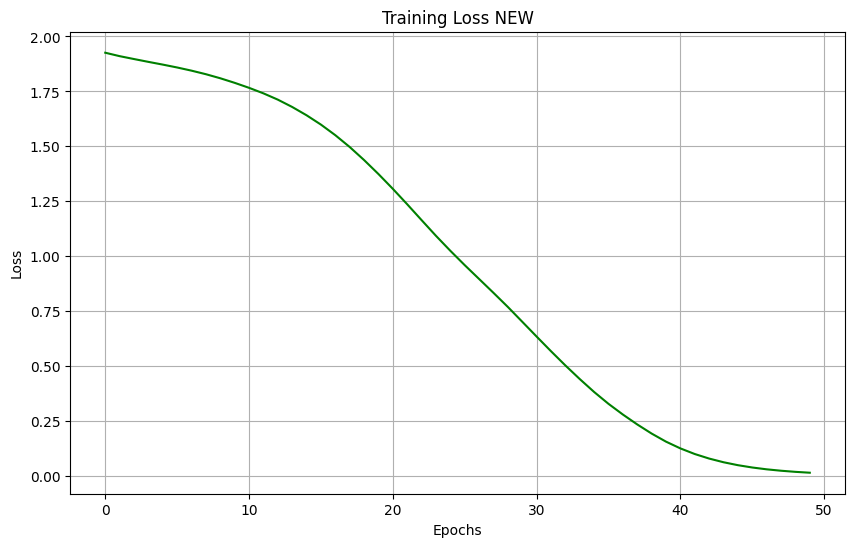

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(train_losses,color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss NEW')
plt.savefig('loss_Layer_NEW.png',dpi = 300)
plt.grid()
plt.show()

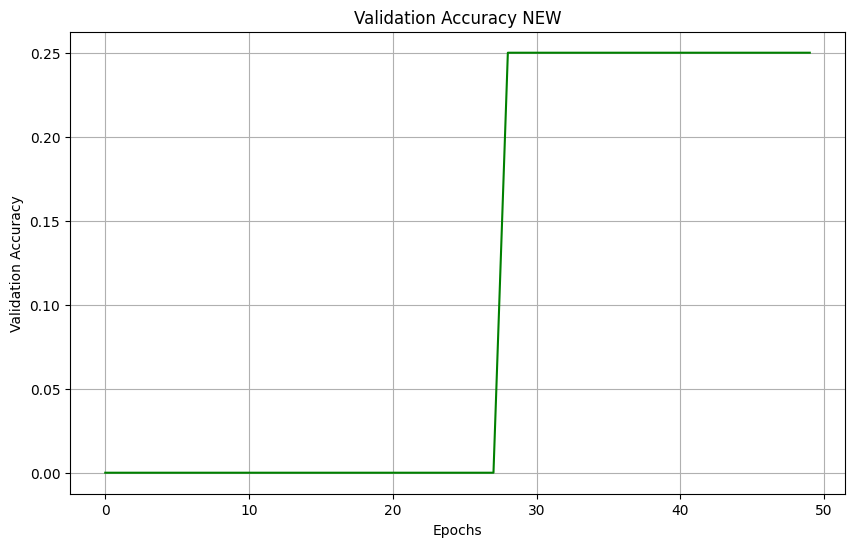

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(val_accuracies,color='green')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy NEW')
plt.savefig('Validation_layer_NEW.png',dpi=300)
plt.grid()
plt.show()